In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline
import sys
print(sys.version)


from qiskit import pulse, QuantumCircuit, ClassicalRegister#, IBMQ

from qiskit_ibm_runtime import QiskitRuntimeService

#from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional


# IBMQ.save_account("TOKEN", overwrite=True)
# Run previous line with the appropriate token
# service = QiskitRuntimeService(channel="ibm_cloud", token="TOKEN", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/b500a23b61df4c36a9f1eef14a04227d:a6e2883a-5882-4f71-9942-1e480bb96768::")
service = QiskitRuntimeService()
print(service)

3.9.11 (v3.9.11:2de452f8bf, Mar 16 2022, 10:34:36) 
[Clang 6.0 (clang-600.0.57)]
<QiskitRuntimeService>


In [2]:
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider.backends()
### SHERBROOKE DETAILS ###
backend = service.backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 0
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [3]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fcc981e2ee0>
backend_name
ibm_sherbrooke
backend_version
1.5.6
n_qubits
127
basis_gates
['ecr', 'id', 'rz', 'sx', 'x']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], 

## Acquisition Scan Analysis
1. Rectangular vs Gaussian Square
2. Varying Amps Rectangular
3. Full Gaussian, varying amplitudes (sufficient std)

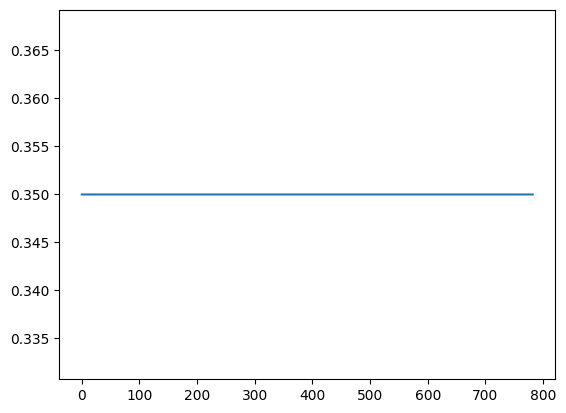

In [8]:
from utils import convert_arr_to_dt, get_dt_from

cal_tau_1 = 75 * ns
cal_tau_2 = 450 * ns
long_tau_3 = 200.0 * ns

meas_pulse_dur_dt = get_dt_from(cal_tau_2 + long_tau_3 + 40. * ns)

flat_meas_pulse = np.ones(measure_pulse.duration) * measure_pulse.amp

plt.plot(np.arange(measure_pulse.duration) / 4.5, flat_meas_pulse)

In [14]:
acq_start_dt = get_dt_from(0. * ns, dt)
acq_end_dt = get_dt_from(1244. * ns, dt)
meas_pulse_dur_dt = (acq_end_dt - acq_start_dt)
num_acq_exp = 57
acq_delay_linspace = np.linspace(acq_start_dt, acq_end_dt, num_acq_exp) * dt
acq_delay_linspace_us = convert_arr_to_dt(acq_delay_linspace)

acq_latency_dt = get_dt_from(750 * ns, dt)
acq_dur_dt = get_dt_from(10.6 * ns, dt)

print(acq_dur_dt*dt/ns)
print(acq_delay_linspace_us/ns)
print(np.diff(acq_delay_linspace_us) / ns)

10.666666666666666
[   0.           21.33333333   42.66666667   67.55555556   88.88888889
  110.22222222  135.11111111  156.44444444  177.77777778  199.11111111
  220.44444444  245.33333333  266.66666667  288.          312.88888889
  334.22222222  355.55555556  376.88888889  398.22222222  423.11111111
  444.44444444  465.77777778  490.66666667  512.          533.33333333
  554.66666667  576.          600.88888889  622.22222222  643.55555556
  668.44444444  689.77777778  711.11111111  732.44444444  753.77777778
  778.66666667  800.          821.33333333  846.22222222  867.55555556
  888.88888889  910.22222222  931.55555556  956.44444444  977.77777778
  999.11111111 1024.         1045.33333333 1066.66666667 1088.
 1109.33333333 1134.22222222 1155.55555556 1176.88888889 1201.77777778
 1223.11111111 1244.44444444]
[21.33333333 21.33333333 24.88888889 21.33333333 21.33333333 24.88888889
 21.33333333 21.33333333 21.33333333 21.33333333 24.88888889 21.33333333
 21.33333333 24.88888889 21.3333

114
114
114
114


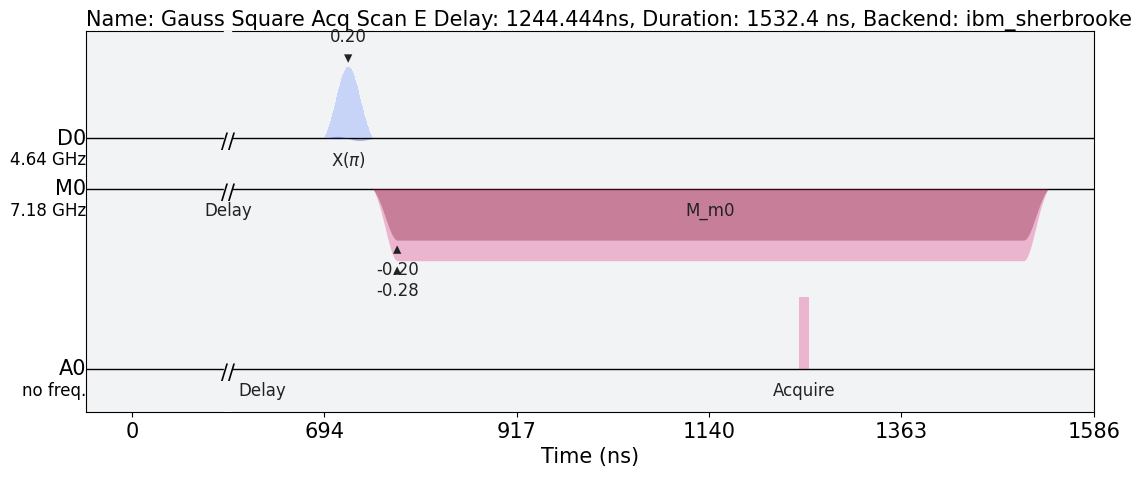

In [18]:
# Making Experiments

standard_exps_g = []
standard_exp_g_circs = []
standard_exps_e = []
standard_exp_e_circs = []

for acq_delay_us in acq_delay_linspace_us:
    acq_delay_dt = get_dt_from(acq_delay_us, dt)
    acq_delay_ns = np.round(acq_delay_us/ns, 3)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Flat Meas Acq Scan G Delay: {acq_delay_ns}ns',
    ) as flat_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(flat_meas_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_g.append(flat_sched_g)
    circ = QuantumCircuit(1,1)
    circ.measure(0,0)
    circ.add_calibration('measure', [0], flat_sched_g)
    standard_exp_g_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Flat Meas Acq Scan E Delay: {acq_delay_ns}ns',
    ) as flat_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(flat_meas_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_e.append(flat_sched_e)
    circ = QuantumCircuit(1,1)
    circ.measure(0,0)
    circ.add_calibration('measure', [0], flat_sched_e)
    standard_exp_e_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Gauss Square Acq Scan G Delay: {acq_delay_ns}ns',
    ) as gauss_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_g.append(gauss_sched_g)
    circ = QuantumCircuit(1,1)
    circ.measure(0,0)
    circ.add_calibration('measure', [0], gauss_sched_g)
    standard_exp_g_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Gauss Square Acq Scan E Delay: {acq_delay_ns}ns',
    ) as gauss_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    standard_exps_e.append(gauss_sched_e)
    circ = QuantumCircuit(1,1)
    circ.measure(0,0)
    circ.add_calibration('measure', [0], gauss_sched_e)
    standard_exp_e_circs.append(circ)

print(len(standard_exps_g))
print(len(standard_exps_e))
print(len(standard_exp_g_circs))
print(len(standard_exp_e_circs))

standard_exps_e[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [24]:
# Varying Amps Rectangular

amps_linspace = np.array([
    measure_pulse.amp, 
    measure_pulse.amp + 0.15,
    measure_pulse.amp + 0.30
])

amp_acq_start_dt = get_dt_from(0. * ns, dt)
amp_acq_end_dt = get_dt_from(700 * ns, dt)
amp_meas_pulse_dur_dt = (amp_acq_end_dt - amp_acq_start_dt)
amp_num_acq_exp = 34
amp_acq_delay_linspace = np.linspace(amp_acq_start_dt, amp_acq_end_dt, amp_num_acq_exp) * dt
amp_acq_delay_linspace_us = convert_arr_to_dt(amp_acq_delay_linspace)

102
102
102
102


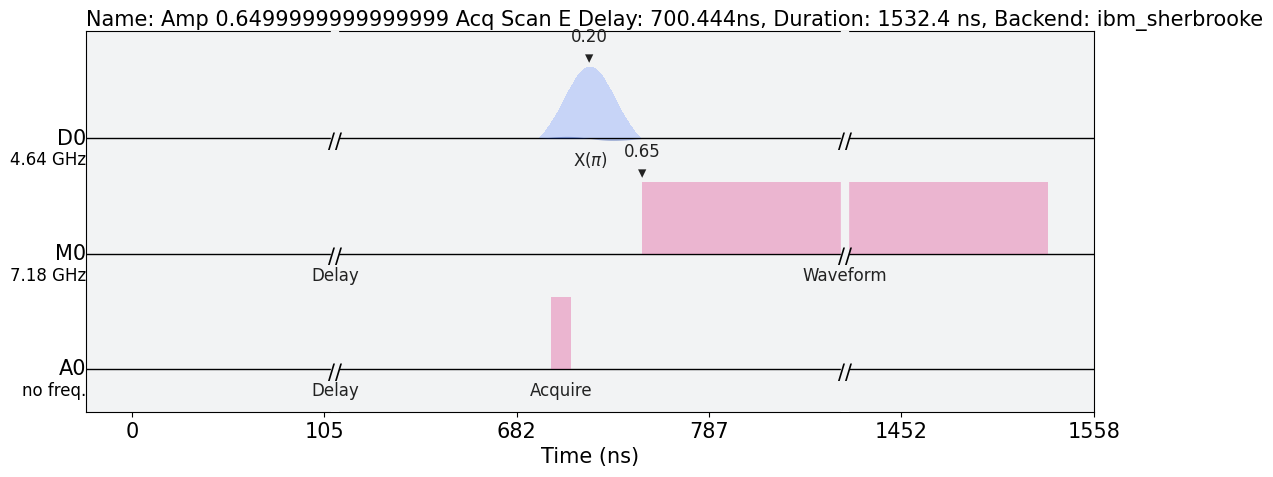

In [25]:
# Making Experiments

amp_exps_g = []
amp_exp_g_circs = []
amp_exps_e = []
amp_exp_e_circs = []

for amp in amps_linspace:
    m_pulse = np.ones(measure_pulse.duration) * amp
    for acq_delay_us in amp_acq_delay_linspace_us:
        acq_delay_dt = get_dt_from(acq_delay_us, dt)
        acq_delay_ns = np.round(acq_delay_us/ns, 3)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Amp {amp} Acq Scan G Delay: {acq_delay_ns}ns',
        ) as amp_sched_g:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                acq_dur_dt,
                qubit,
                pulse.MemorySlot(qubit),
            )
        amp_exps_g.append(amp_sched_g)
        circ = QuantumCircuit(1,1)
        circ.measure(0,0)
        circ.add_calibration('measure', [0], amp_sched_g)
        amp_exp_g_circs.append(circ)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Amp {amp} Acq Scan E Delay: {acq_delay_ns}ns',
        ) as amp_sched_e:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(acq_latency_dt, meas_chan)
            pulse.play(m_pulse, meas_chan)
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                acq_dur_dt,
                qubit,
                pulse.MemorySlot(qubit),
            )
        amp_exps_e.append(amp_sched_e)
        circ = QuantumCircuit(1,1)
        circ.measure(0,0)
        circ.add_calibration('measure', [0], amp_sched_e)
        amp_exp_e_circs.append(circ)

print(len(amp_exps_g))
print(len(amp_exps_e))
print(len(amp_exp_g_circs))
print(len(amp_exp_e_circs))

amp_exps_e[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [27]:
from utils import acquisition_checker

batch_1 = standard_exps_g + standard_exps_e
batch_2 = amp_exps_g + amp_exps_e
batch_1_circ = standard_exp_g_circs + standard_exp_e_circs
batch_2_circ = amp_exp_g_circs + amp_exp_e_circs

print(len(batch_1_circ))
print(len(batch_2_circ))

acquisition_checker(batch_1, backend)
acquisition_checker(batch_2, backend)

num_shots = 4096
rep_delay = 1.0 * us

228
204


In [28]:
# Running total_job

job_experiment = backend.run(batch_1_circ, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

print(job_experiment)

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_45441/863620186.py:3: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_experiment = backend.run(batch_1_circ,
/Users/chatt07/Desktop/new_readout_env/lib/python3.9/site-packages/qiskit_ibm_runtime/ibm_backend.py:711: UserWarning: The backend ibm_sherbrooke is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


<RuntimeJob('ctvyan2seb10008x462g', 'circuit-runner')>


In [29]:
job_experiment_2 = backend.run(batch_2_circ, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

print(job_experiment_2)

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_45441/1505513046.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_experiment_2 = backend.run(batch_2_circ,
/Users/chatt07/Desktop/new_readout_env/lib/python3.9/site-packages/qiskit_ibm_runtime/ibm_backend.py:711: UserWarning: The backend ibm_sherbrooke is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


<RuntimeJob('ctvyawbezn20008sgkjg', 'circuit-runner')>
